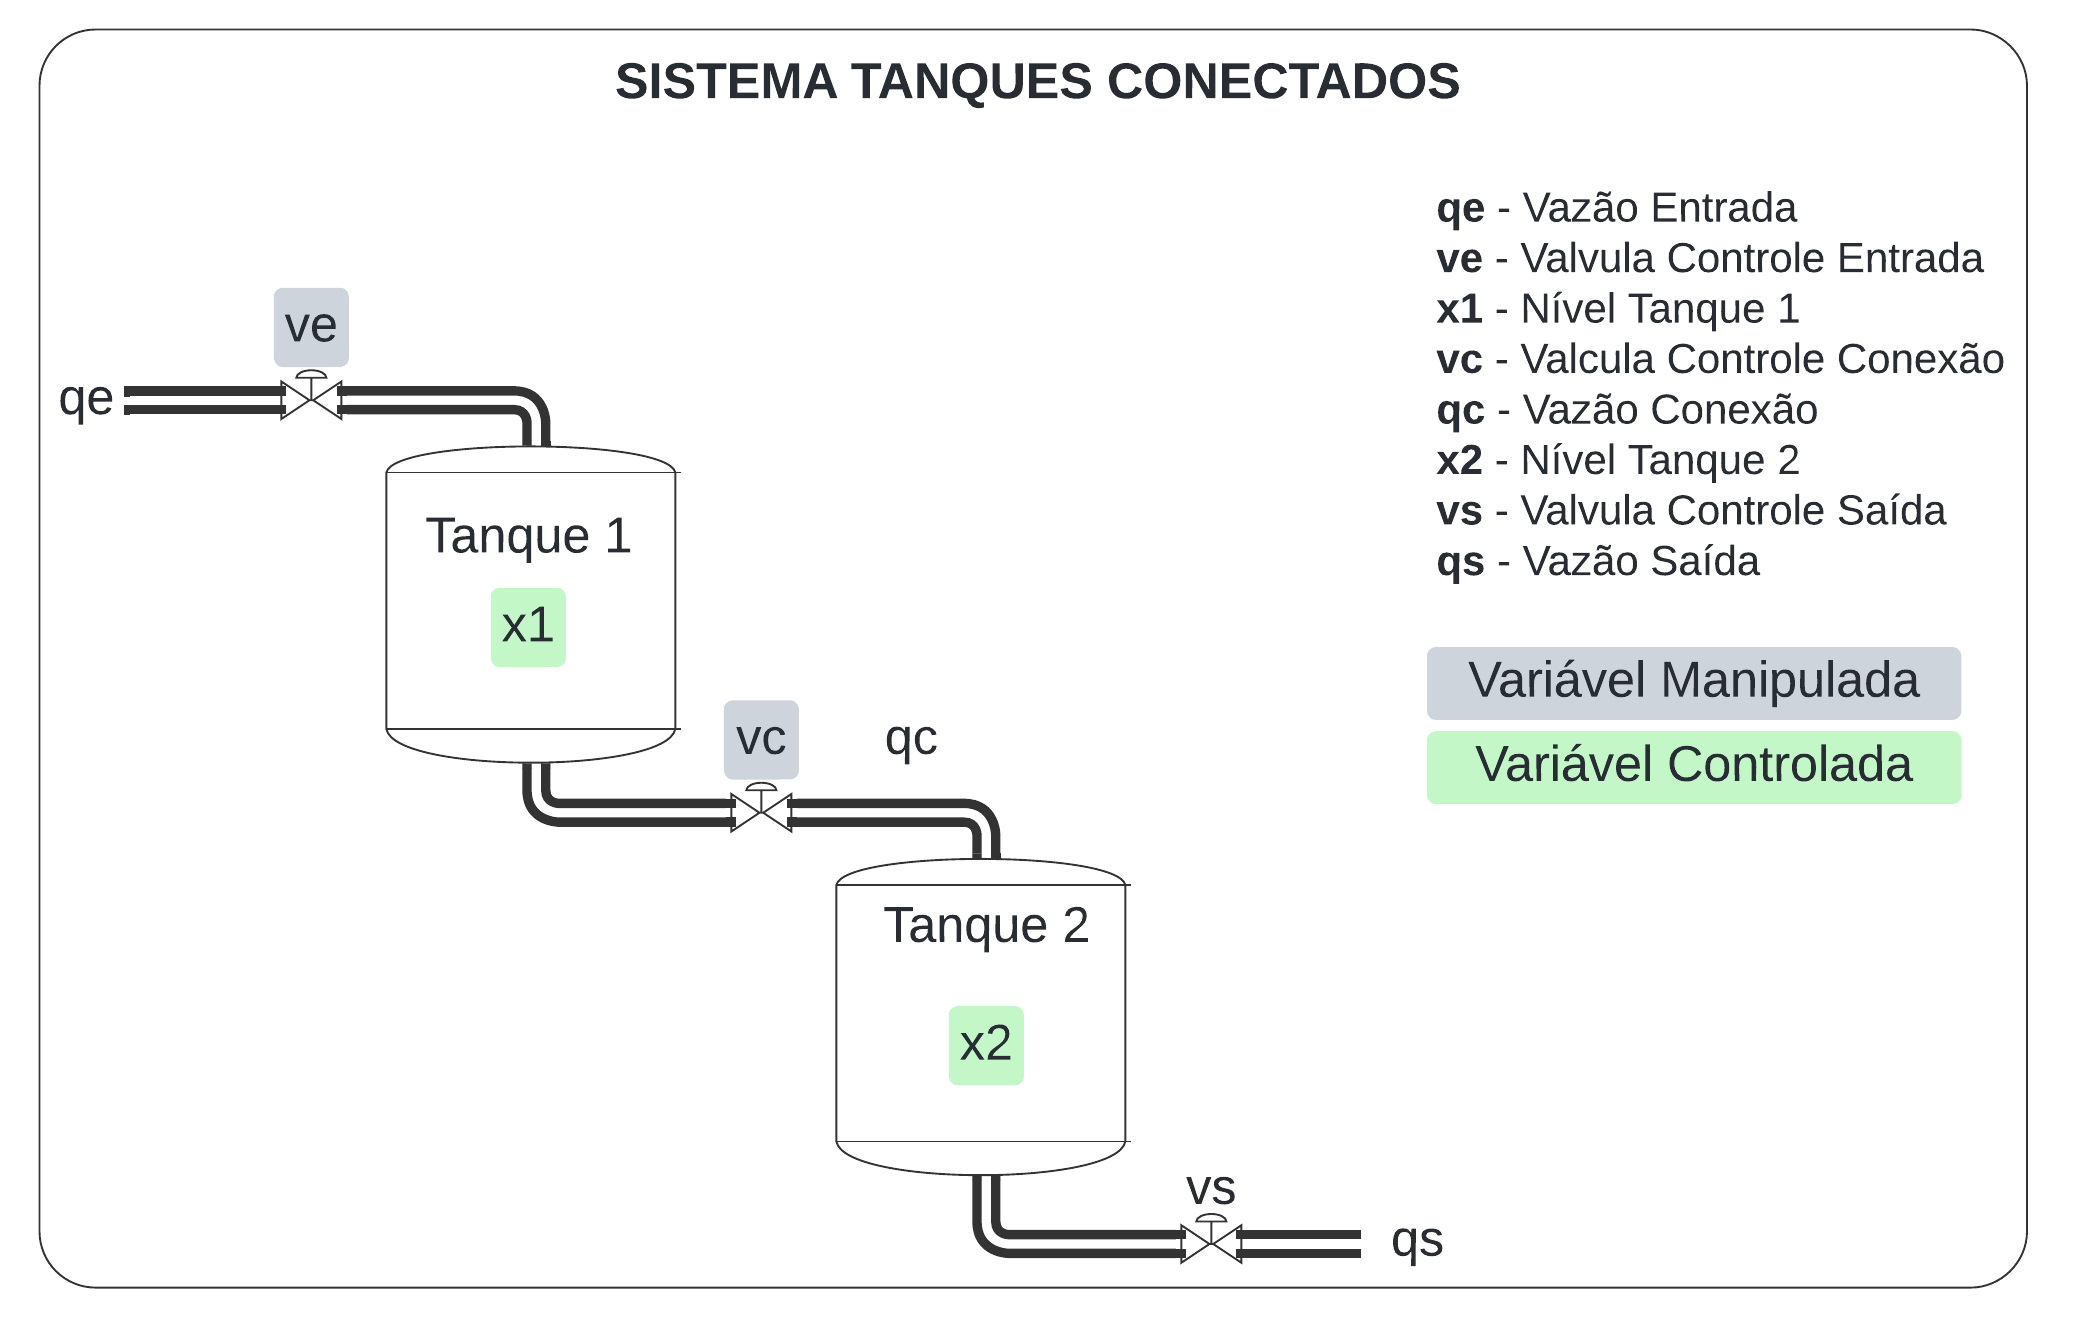

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import joblib
import os

In [7]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.width', 1000)

In [8]:
def plotCorrrelation(df):
  # Pearson
  pearson = df.corr(method='pearson')
  mask_pearson = np.triu(np.ones_like(pearson, dtype=bool))
  # Spearman
  spearman = df.corr(method='spearman')
  mask_spearman = np.triu(np.ones_like(spearman, dtype=bool))

  #Print heatmap
  sns.set_theme(style='darkgrid')
  fig, ax = plt.subplots(1,2,figsize=(26,10))
  sns.heatmap(data=pearson, annot=True, mask=mask_pearson, ax=ax[0])
  ax[0].set_title("Pearson")
  sns.heatmap(data=spearman, annot=True, mask=mask_spearman, ax=ax[1])
  ax[1].set_title("Spearman")
  fig.suptitle('Map Variables')
  fig.show()
  fig.savefig(f'{plot_name}-corrrelation.png', format='png', dpi=600)

Processo que representa um o nível de um tanque com um registro

In [9]:
# Process Const
area = 16
max_level = 12
def tank_xdot(x, qe, valve=100, valve_k = 1):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, valve_k = 1, t=0.2):
  a=x0
  b=qe
  c=valve
  #call 1
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  if np.isnan(x):
    x = 0

  if np.isnan(qs):
    qs = 0

  return x, qs;

In [10]:
# Parametros Globais
np.random.seed(56)
k1 = 2
k2 = 1
ts = 0.3
model_horizon = 5
num_data = 10000
data_name = f"data-{num_data}_hor-{model_horizon}_ts-{ts}"

plot_name = f'pmc_nn-2tanques_{data_name}'
path = f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_{data_name}'
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)
print(f'O diretório  é: {os.getcwd()}')
print(f'O plot_name  é: {plot_name}')

O diretório  é: /content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_data-10000_hor-5_ts-0.3
O plot_name  é: pmc_nn-2tanques_data-10000_hor-5_ts-0.3


Geração de Dados de Treinamento

In [11]:
data_columns = ["x1", "qe", "vc", "x2", "vs", "diff1", "diff2"]
data = np.zeros((0,len(data_columns)))

qe = np.random.choice(np.arange(0, 4.001, 0.01), num_data)
vc = np.random.choice(np.arange(0, 101, 1), num_data)
vs = np.random.choice(np.arange(0, 101, 1), num_data)
x1 = np.random.choice(np.arange(0, 13, 0.01), num_data)
x2 = np.random.choice(np.arange(0, 13, 0.01), num_data)
x = [0, 0];

for t in range(num_data):

    x[0] = x1[t]
    x[1] = x2[t]

    for _ in range(model_horizon):
      x[0], qc = tank_rk(x[0], qe[t], vc[t], k1, ts);
      x[1], qs = tank_rk(x[1], qc   , vs[t], k2, ts);

    new = np.hstack((x1[t], qe[t], vc[t], x2[t], vs[t], x[0] - x1[t], x[1] - x2[t]))
    data = np.vstack((data, new))


data=pd.DataFrame(data = data, columns = data_columns)
data

Output hidden; open in https://colab.research.google.com to view.

In [12]:
data.describe()

,x1,qe,vc,x2,vs,diff1,diff2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.498224,1.994962,49.800200,6.434528,49.912500,-0.078272,0.064868
std,3.761022,1.168179,29.037913,3.774669,28.993184,0.260338,0.250697
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.411558,-1.186118
25%,3.240000,0.970000,25.000000,3.150000,25.000000,-0.194915,-0.040041
50%,6.450000,1.975000,50.000000,6.370000,50.000000,-0.035718,0.073882
75%,9.692500,3.020000,75.000000,9.762500,74.000000,0.093509,0.220029
max,12.990000,4.000000,100.000000,12.990000,100.000000,0.375000,0.643323


Processamento dos Dados

In [13]:
data = data.dropna()
data.std()

x1        3.761022
qe        1.168179
vc       29.037913
x2        3.774669
vs       28.993184
diff1     0.260338
diff2     0.250697
dtype: float64

In [14]:
x_train = data[["x1", "qe", "vc","x2", "vs"]]
y_train = data[["diff1", "diff2"]]

In [15]:
x_train.describe()

,x1,qe,vc,x2,vs
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.498224,1.994962,49.800200,6.434528,49.912500
std,3.761022,1.168179,29.037913,3.774669,28.993184
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.240000,0.970000,25.000000,3.150000,25.000000
50%,6.450000,1.975000,50.000000,6.370000,50.000000
75%,9.692500,3.020000,75.000000,9.762500,74.000000
max,12.990000,4.000000,100.000000,12.990000,100.000000


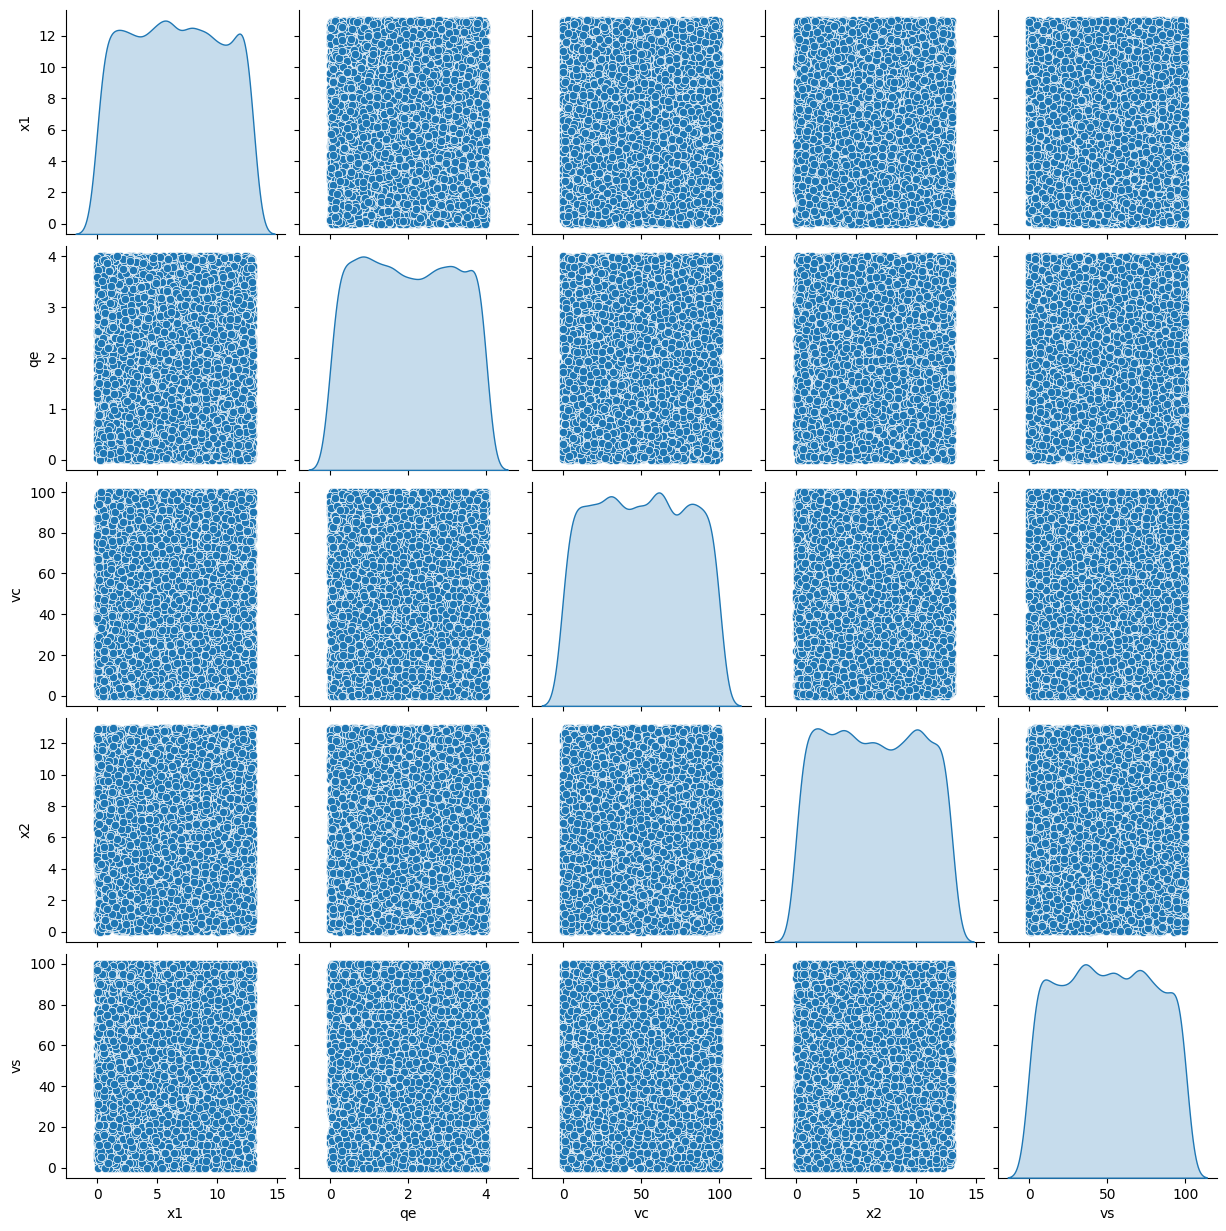

In [16]:
pairplot  = sns.pairplot(x_train, diag_kind="kde")
pairplot.savefig(f'{plot_name}-pairplot.png', format='png', dpi=600)

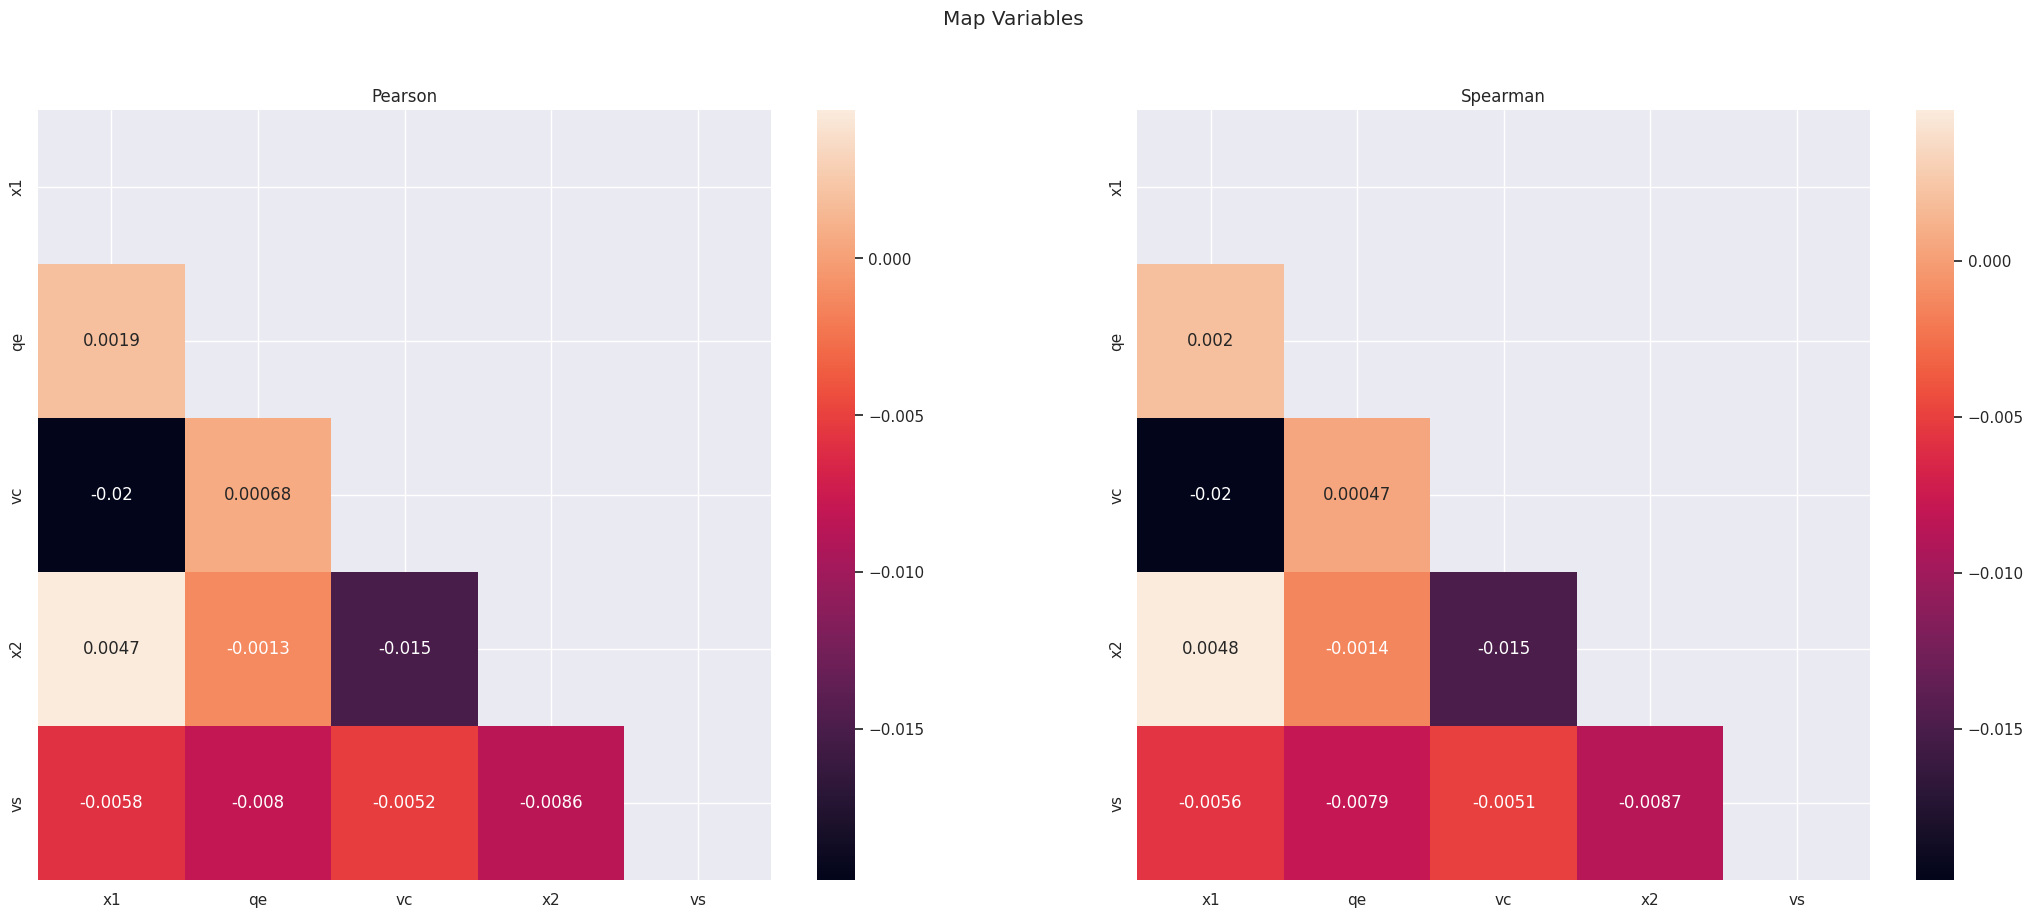

In [17]:
plotCorrrelation(x_train)

In [18]:
x_train=x_train.values
y_train=y_train.values

In [19]:
scaler_x_train = StandardScaler()
x_train = scaler_x_train.fit_transform(x_train)
x_train

array([[-0.92485452,  1.21138008,  0.45459396, -1.03710375, -1.06625219],
       [ 0.57481298,  1.70790417, -1.61177354,  1.43740889, -0.99726701],
       [-1.48590034, -0.06417317,  1.28114097, -1.52723741, -0.13495226],
       ...,
       [ 0.63862862,  1.2713054 , -0.23419521,  0.85719661, -0.85929665],
       [ 0.90452711,  0.16696735,  0.66123071, -0.610555  ,  0.07200328],
       [-1.50451323,  1.60517505, -0.78522654, -1.32323583,  0.86533285]])

In [20]:
data.to_csv(f"datatrain_{data_name}.csv", index=False)
np.save(f"datatrain-x_{data_name}.npy", x_train)
np.save(f"datatrain-y_{data_name}.npy", y_train)
joblib.dump(scaler_x_train, f"datatrain_scaler-x_{data_name}.pkl")

['datatrain_scaler-x_data-10000_hor-5_ts-0.3.pkl']